In [1]:
import os
import shutil

import pandas as pd
import tensorflow as tf
import numpy as np
import keras
from keras import Input
from keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Lambda,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

print(tf.__version__)

2023-02-08 15:08:33.918592: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 15:08:34.773333: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-08 15:08:34.773429: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

2.11.0


In [2]:
#read data
data = pd.read_csv("./data/train.csv")
#shuffle data
data = data.sample(frac=1)

#print data
#data.head(10)
#data["keyword"].unique()

In [3]:
#one hot encode target
classes = [[0,1][source] for source in data.target]
target = to_categorical(classes)
#print target
target[10]

array([1., 0.], dtype=float32)

In [4]:
MAX_LEN = 22
MAX_TOKENS = 100000

preprocessing_layer = TextVectorization(
    output_sequence_length=MAX_LEN, 
    max_tokens=MAX_TOKENS
    #, vocabulary = np.array(["Our","are", "in"])
)

2023-02-08 15:08:37.361025: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 15:08:37.373308: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 15:08:37.375108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-08 15:08:37.377176: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [5]:
preprocessing_layer.adapt(data.text)


In [6]:
preprocessing_layer(data.text[:10])

<tf.Tensor: shape=(10, 22), dtype=int64, numpy=
array([[ 8671,   725,  2455,   595,    16,    93,    12,   578,    40,
            2,  7017,   204, 17340,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [19087,   297,  5958,    11,  1995,   680,     3,    89,   174,
            4,   610,  1185,     2,   360,     6,  1566,  8914,     4,
         4824, 13359,  9196,     0],
       [    2,  1937,  9328,   192,     6,     2, 18387,   784,   420,
           38,  3203,     3,  8557,  9901,     4,  3594, 15829, 15932,
            0,     0,     0,     0],
       [19677, 19110, 11459,   516,    11, 19523, 22512, 16122,  4202,
            7,  6549,   848,  3086, 14191,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  868,    59,   581,    16, 19274,  2341,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [ 1166,    58,   100, 12793,   305, 10246,   706, 

In [7]:
VOCAB_SIZE = len(preprocessing_layer.get_vocabulary())
VOCAB_SIZE

22699

In [8]:
inputs = Input(shape=(1,),dtype=tf.string)
x = preprocessing_layer(inputs)
x = Embedding(VOCAB_SIZE+1,5,input_shape=[22],mask_zero=True)(x)
x = Conv1D(filters=200, kernel_size=3,strides=2,activation="relu")(x)
x = Flatten()(x)
outputs = Dense(2,activation="softmax")(x)

model = keras.Model(inputs=inputs,outputs=outputs,name="modeltest")
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy",metrics=["Accuracy"])

Model: "modeltest"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 22)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 22, 5)             113500    
                                                                 
 conv1d (Conv1D)             (None, 10, 200)           3200      
                                                                 
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 dense (Dense)               (None, 2)                 4002      
                                                         

In [9]:
# model = Sequential([
#     Input(shape=(1,),dtype=tf.string),
#     preprocessing_layer,
#     Embedding(
#             VOCAB_SIZE+1, 5, input_shape=[22], mask_zero=True
#     ),
#     #Lambda(lambda x:tf.reduce_mean(x,axis=1)),
#     GRU(8),
#     Dense(2,activation="softmax")
# ])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy",metrics=["Accuracy"])

In [10]:
modelhistory = model.fit(
    data.text[:6000],
    target[:6000], 
    epochs=50,
    batch_size=50, 
    validation_data=(data.text[6000:],target[6000:]),
    # callbacks=[EarlyStopping(patience=10)]
)

Epoch 1/50


2023-02-08 15:08:40.345885: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-02-08 15:08:41.649258: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f47bb4fc940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-08 15:08:41.649300: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-02-08 15:08:41.655476: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-08 15:08:41.802839: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


120/120 [==============================] - 14s 91ms/step - loss: 0.6438 - Accuracy: 0.6170 - val_loss: 0.5371 - val_Accuracy: 0.7396
Epoch 2/50
120/120 [==============================] - 5s 43ms/step - loss: 0.3853 - Accuracy: 0.8328 - val_loss: 0.4822 - val_Accuracy: 0.7743
Epoch 3/50
120/120 [==============================] - 2s 14ms/step - loss: 0.2012 - Accuracy: 0.9253 - val_loss: 0.5403 - val_Accuracy: 0.7917
Epoch 4/50
120/120 [==============================] - 2s 18ms/step - loss: 0.0997 - Accuracy: 0.9672 - val_loss: 0.6462 - val_Accuracy: 0.7650
Epoch 5/50
120/120 [==============================] - 2s 16ms/step - loss: 0.0549 - Accuracy: 0.9820 - val_loss: 0.7181 - val_Accuracy: 0.7706
Epoch 6/50
120/120 [==============================] - 2s 14ms/step - loss: 0.0350 - Accuracy: 0.9885 - val_loss: 0.7937 - val_Accuracy: 0.7694
Epoch 7/50
120/120 [==============================] - 1s 9ms/step - loss: 0.0266 - Accuracy: 0.9923 - val_loss: 0.8450 - val_Accuracy: 0.7657
Epoch 8/50

<AxesSubplot:>

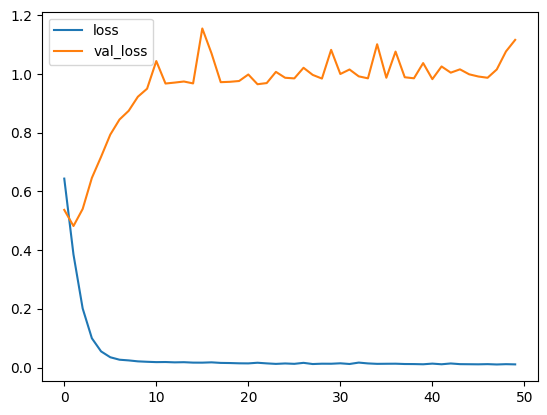

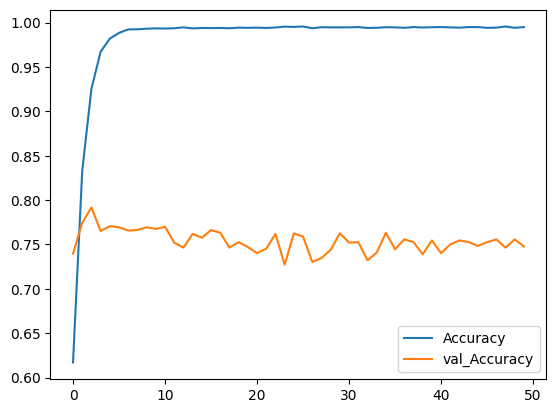

In [11]:
pd.DataFrame(modelhistory.history)[["loss","val_loss"]].plot()
pd.DataFrame(modelhistory.history)[["Accuracy","val_Accuracy"]].plot()

<AxesSubplot:>

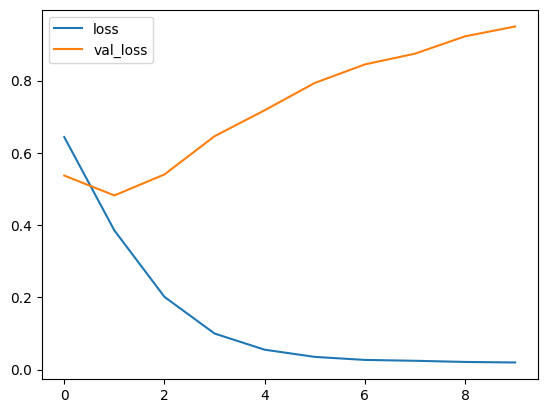

In [12]:
pd.DataFrame(modelhistory.history)[["loss","val_loss"]][:10].plot()

In [13]:
model.predict(data.text[7000:7001])

1/1 [==============================] - 0s 126ms/step


array([[2.5069755e-06, 9.9999750e-01]], dtype=float32)

In [14]:
data.text[7000:7001]

7423    Police Officer Wounded Suspect Dead After Exch...
Name: text, dtype: object